In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
#import _pickle as pickle
import pickle
import re, sys, unidecode
#import unidecode

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil
import os

# Representation
import nltk
from nltk.corpus import stopwords
import scikitplot as skplt

#plt.style.use('fivethirtyeight')


import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Parameters

In [2]:
root_path = "../"
path_model = root_path + 'models/test'
features_path = root_path + 'data/features/dataset_tfid_hash28_n1000.p'

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

In [3]:
X_train,y_train,X_test,y_test = pickle.load( open( features_path, "rb" ) )


In [4]:
labels = list(set(y_train))
labels.sort()
nClasses = len(labels)

def calcWeights(y):
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,2) # 1.4
    return weights 

# #lerko
# scale_factor = 10e3
# sizes = {label: y_train[y_train == label].shape[0] for label in labels}
# weights = np.asarray([scale_factor/sizes[label] for label in y])

weights_train = calcWeights(y_train)
weights_test = calcWeights(y_test)


In [5]:
set(weights_train)

{0.15264421200110437,
 0.1578951896320362,
 0.8812478724488313,
 1.0281105869222957,
 10.791044257978275,
 17.6036413826886,
 19.675337603358503,
 92.13646452530024}

In [6]:
labels

y_train_new = []
for yTmp in y_train:
    for idx, label in enumerate(labels):
        if yTmp==label: 
            y_train_new.append(idx)
            
y_test_new = []
for yTmp in y_test:
    for idx, label in enumerate(labels):
        if yTmp==label: 
            y_test_new.append(idx)            


# Model



In [7]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train_new, weight= weights_train)
#lgb_train = lgb.Dataset(X_train, y_train_new)
lgb_eval = lgb.Dataset(X_test, y_test_new, reference=lgb_train)


In [8]:
# specify your configurations as a dict
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass',
#     'num_class':nClasses,
#     'metric' : "multi_logloss",
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 1,
#     #'
# }

# leave 31 def
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class':nClasses,
    'metric': 'multi_logloss',
    'learning_rate': 0.4,#0.4
    'min_data_in_leaf':50, #60 ,50     
    'max_depth':-1,
    'num_leaves': 71,#31 , 71
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': -1,
    'verbose': 1,    
    'num_threads':24}

start = time.time()
print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=6,
                )

end = time.time()
print("training time :" + str(end - start) )

Start training...
[1]	valid_0's multi_logloss: 1.62498
Training until validation scores don't improve for 6 rounds.
[2]	valid_0's multi_logloss: 1.48626
[3]	valid_0's multi_logloss: 1.40055
[4]	valid_0's multi_logloss: 1.33728
[5]	valid_0's multi_logloss: 1.28472
[6]	valid_0's multi_logloss: 1.24581
[7]	valid_0's multi_logloss: 1.20942
[8]	valid_0's multi_logloss: 1.17029
[9]	valid_0's multi_logloss: 1.13596
[10]	valid_0's multi_logloss: 1.09763
[11]	valid_0's multi_logloss: 1.06418
[12]	valid_0's multi_logloss: 1.03717
[13]	valid_0's multi_logloss: 1.01033
[14]	valid_0's multi_logloss: 0.978823
[15]	valid_0's multi_logloss: 0.950413
[16]	valid_0's multi_logloss: 0.926412
[17]	valid_0's multi_logloss: 0.901131
[18]	valid_0's multi_logloss: 0.87831
[19]	valid_0's multi_logloss: 0.857128
[20]	valid_0's multi_logloss: 0.835833
[21]	valid_0's multi_logloss: 0.818945
[22]	valid_0's multi_logloss: 0.802258
[23]	valid_0's multi_logloss: 0.783765
[24]	valid_0's multi_logloss: 0.768932
[25]	val

# performance


/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


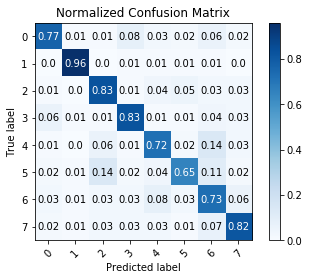

## Accuracy in test: 79.34636965078302 

In [9]:
preds =  gbm.predict(X_test)
predictions = []
for x in preds:
    predictions.append(np.argmax(x))
    
y_test_hat = predictions


skplt.metrics.plot_confusion_matrix(y_test_new, y_test_hat,normalize=True)
plt.xticks(rotation=45)
plt.show()

acc = accuracy_score(y_true=y_test_new, y_pred=y_test_hat)

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


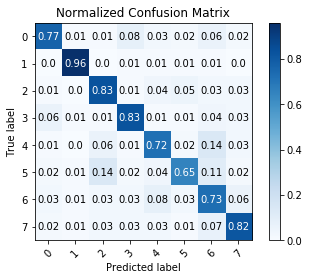

## Accuracy in test: 79.34636965078302 

In [10]:
preds =  gbm.predict(X_test)
predictions = []
for x in preds:
    predictions.append(np.argmax(x))
    
y_test_hat = predictions


skplt.metrics.plot_confusion_matrix(y_test_new, y_test_hat,normalize=True)
plt.xticks(rotation=45)
plt.show()

acc = accuracy_score(y_true=y_test_new, y_pred=y_test_hat)

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))